In [9]:
# set multi print in one cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [85]:
import mxnet as mx
import numpy as np 
from pprint import pprint 

In [2]:
import numpy as np
import os
import urllib
import gzip
import struct
def download_data(url, force_download=True): 
    fname = url.split("/")[-1]
    if force_download or not os.path.exists(fname):
        urllib.urlretrieve(url, fname)
    return fname

def read_data(label_url, image_url):
    with gzip.open(download_data(label_url)) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(download_data(image_url), 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return (label, image)

path='http://yann.lecun.com/exdb/mnist/'
(train_lbl, train_img) = read_data(
    path+'train-labels-idx1-ubyte.gz', path+'train-images-idx3-ubyte.gz')
(val_lbl, val_img) = read_data(
    path+'t10k-labels-idx1-ubyte.gz', path+'t10k-images-idx3-ubyte.gz')

In [115]:
def to4d(img):
    return img.reshape(img.shape[0], 1, 28, 28).astype(np.float32)/255

def oneHot(labels, num_class = 10):
    ret = np.zeros((labels.shape[0], num_class))
    ind = labels
    ret[np.arange(labels.shape[0]) ,ind] = 1
    return  ret 

train_label= oneHot(train_lbl)
val_label = oneHot(val_lbl)

batch_size = 25
train_iter = mx.io.NDArrayIter(to4d(train_img), train_label, batch_size, shuffle=True, label_name = 'label')
val_iter = mx.io.NDArrayIter(to4d(val_img), val_label, batch_size, label_name='label')

train_iter2 = mx.io.NDArrayIter(to4d(train_img), train_label, batch_size, shuffle=True, label_name = 'label')
val_iter2 = mx.io.NDArrayIter(to4d(val_img), val_label, batch_size, label_name='label')

pprint(train_lbl.shape)

(60000,)


In [116]:
pprint(train_label[0:10])

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])


In [117]:
train_iter.data
train_iter.label
train_iter.provide_data
train_iter.provide_label

[('data', <NDArray 60000x1x28x28 @cpu(0)>)]

[('label', <NDArray 60000x10 @cpu(0)>)]

[DataDesc[data,(25, 1L, 28L, 28L),<type 'numpy.float32'>,NCHW]]

[DataDesc[label,(25, 10L),<type 'numpy.float32'>,NCHW]]

In [118]:
batch = train_iter.next()
batch.data
batch.label
train_iter.reset()

[<NDArray 25x1x28x28 @cpu(0)>]

[<NDArray 25x10 @cpu(0)>]

In [119]:
# create symbol 
def get_sym(num_class = 10):
    data = mx.sym.Variable('data')
    label = mx.sym.Variable('label')
    conv1 = mx.sym.Convolution(data = data, kernel = (3,3), num_filter = 16, pad = (1,1),name='conv1')
    acti = mx.sym.Activation(data= conv1, act_type = 'relu',name='act1')
    fc1 = mx.sym.FullyConnected(data=acti, num_hidden = 10, name='fc1' )
    fc2 = mx.sym.FullyConnected(data=fc1,num_hidden =1, name='fc2')
    err = (fc2 - label) **2
    loss = mx.sym.MakeLoss(data = err, name= 'loss')
    net = loss
    
    return net  

[('data', (25L, 3L, 28L, 28L)),
 ('conv1_weight', (16L, 3L, 3L, 3L)),
 ('conv1_bias', (16L,)),
 ('conv1_output', (25L, 16L, 28L, 28L)),
 ('act1_output', (25L, 16L, 28L, 28L)),
 ('fc1_weight', (10L, 12544L)),
 ('fc1_bias', (10L,)),
 ('fc1_output', (25L, 10L)),
 ('fc2_weight', (1L, 10L)),
 ('fc2_bias', (1L,)),
 ('fc2_output', (25L, 1L)),
 ('label', (25L, 1L)),
 ('_minus24_output', (25L, 1L)),
 ('_powerscalar24_output', (25L, 1L)),
 ('loss_output', (25L, 1L))]


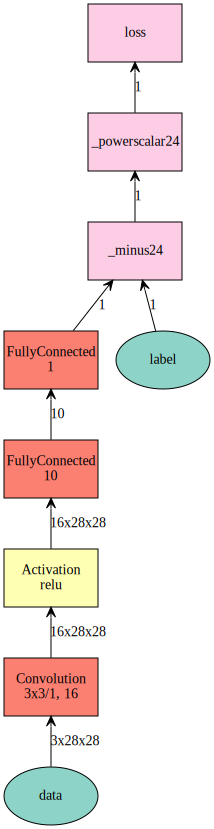

In [121]:
net = get_sym()
data_shape_dict = {'data':(batch_size,3,28,28), 'label':(batch_size,1)}
net_all = net.get_internals()
arg_shape, out_shape, aux_shape = net_all.infer_shape(**data_shape_dict)
pprint( zip(net_all.list_outputs(),out_shape))
mx.viz.plot_network(net, shape= data_shape_dict)

### try Costum Ops

#####  using MakeLoss 

In [112]:
ctx = mx.gpu(2)
mod = mx.mod.Module(symbol = net, context = ctx, 
                    data_names =['data'], 
                    label_names = ['label'])

In [122]:
import logging 
logging.basicConfig(level=logging.INFO)
mod.fit(train_data=train_iter2, 
        eval_data= val_iter2, 
        eval_metric= 'mse',
        num_epoch=5)


INFO:root:Epoch[0] Train-mse=0.087479
INFO:root:Epoch[0] Time cost=4.424
INFO:root:Epoch[0] Validation-mse=0.088217
INFO:root:Epoch[1] Train-mse=0.087927
INFO:root:Epoch[1] Time cost=4.064
INFO:root:Epoch[1] Validation-mse=0.088574
INFO:root:Epoch[2] Train-mse=0.088335
INFO:root:Epoch[2] Time cost=4.499
INFO:root:Epoch[2] Validation-mse=0.088863
INFO:root:Epoch[3] Train-mse=0.088679
INFO:root:Epoch[3] Time cost=4.491
INFO:root:Epoch[3] Validation-mse=0.089126
INFO:root:Epoch[4] Train-mse=0.088963
INFO:root:Epoch[4] Time cost=4.322
INFO:root:Epoch[4] Validation-mse=0.089323


In [19]:
?mx.sym.FullyConnected